In [1]:
import nibabel as nib
import numpy as np

import matplotlib.pyplot as plt  
import matplotlib.cm as cm  
from scipy.signal import savgol_filter

m_nifti_file = '/Volumes/Extreme SSD/工程/TpOT/data/Processed_M/1/ep2d_fid_basic_bold_p2_18.nii.gz'

y_nifti_file = '/Volumes/Extreme SSD/工程/TpOT/data/Processed_Y/1/ep2d_fid_basic_bold_p2_24.nii.gz'

In [ ]:
from nilearn import datasets, image
img_m = nib.load(m_nifti_file)
img_y = nib.load(y_nifti_file)

# 计算每个体素的平均时序
data_m = img_m.get_fdata()     
data_y = img_y.get_fdata()
mean_m = np.mean(data_m, axis=3)   
mean_y = np.mean(data_y, axis=3)

#获取 Yeo7 网络模板
yeo = datasets.fetch_atlas_yeo_2011()
atlas_yeo7 = nib.load(yeo.thick_7)    # 原始 2mm 模板

# 重采样到需要的的 fMRI 空间
atlas_res = image.resample_img(
    atlas_yeo7,
    target_affine=img_m.affine,
    target_shape=img_m.shape[:3],
    interpolation='nearest'
)
yeo7_data_m = atlas_res.get_fdata().astype(int)  # 值域 1–7

atlas_res = image.resample_img(
    atlas_yeo7,
    target_affine=img_y.affine,
    target_shape=img_y.shape[:3],
    interpolation='nearest'
)
yeo7_data_y = atlas_res.get_fdata().astype(int)  # 值域 1–7

# 提取各网络的掩模和平均信号
yeo7_labels = {
    1: 'Visual',
    2: 'Somatomotor',
    3: 'DorsalAttention',
    4: 'VentralAttention',
    5: 'Limbic',
    6: 'Frontoparietal',
    7: 'DefaultMode'
}


[get_dataset_dir] Dataset found in /Users/yxzuji/nilearn_data/yeo_2011


/var/folders/vh/pjl542w16gz9d4ftq8k0gxmh0000gn/T/ipykernel_14235/280487564.py:16: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_res = image.resample_img(
/var/folders/vh/pjl542w16gz9d4ftq8k0gxmh0000gn/T/ipykernel_14235/280487564.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_res = image.resample_img(
/var/folders/vh/pjl542w16gz9d4ftq8k0gxmh0000gn/T/ipykernel_14235/280487564.py:24: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_res = image.resample_img(
/var/folders/vh/pjl542w16gz9d4ftq8k0gxmh0000gn/T/ipykernel_14235/280487564.py:24: FutureWarning: From release 0.13.0 on

'\nm_network_mean = {}\ny_network_mean = {}\n\nfor net_id, net_name in yeo7_labels.items():\n    mask = (yeo7_data == net_id)             # bool 掩模\n    if mask.sum() == 0:\n        continue\n\n\n    # ① 如果用平均时序\n    m_network_mean[net_name] = mean_m[mask].mean()\n    y_network_mean[net_name] = mean_y[mask].mean()\n\n    # ② 如果想保留完整的空间结构 (64,64,34)，可这样做：\n    #   m_net_map = np.zeros_like(mean_m)\n    #   m_net_map[mask] = mean_m[mask]\n    #   nib.Nifti1Image(m_net_map, img_m.affine).to_filename(f\'m_net_{net_name}.nii.gz\')\n\n# 7. 输出检查\nprint("M 组各网络平均信号：", m_network_mean)\nprint("Y 组各网络平均信号：", y_network_mean)\n'

In [3]:
yeo7_data_m = np.squeeze(yeo7_data_m, axis=3)
yeo7_data_y = np.squeeze(yeo7_data_y, axis=3)

In [ ]:
unique_vals = np.unique(yeo7_data_m)

m_roi = {}
y_roi = {}

# 遍历 unique_vals
for val in unique_vals:
    if val == 0:
        continue  

    mask = (yeo7_data_m == val)            # 用真实编号做掩模
    if mask.sum() == 0:                   # 再次检查
        continue

    
    idxs = np.array(np.nonzero(mask)).T  

    vals = mean_m[mask]   

    points4d = np.concatenate([
        idxs,                              # (num_points, 3)
        vals[:, np.newaxis]               # (num_points, 1)
    ], axis=1)     

    m_roi[int(val)] = points4d

for val in unique_vals:
    if val == 0:
        continue  

    mask = (yeo7_data_y == val)            # 用真实编号做掩模
    if mask.sum() == 0:                 
        continue

    
    idxs = np.array(np.nonzero(mask)).T  

    vals = mean_y[mask]   

    points4d = np.concatenate([
        idxs,                              # (num_points, 3)
        vals[:, np.newaxis]               # (num_points, 1)
    ], axis=1)     

    y_roi[int(val)] = points4d


/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/tpot/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all

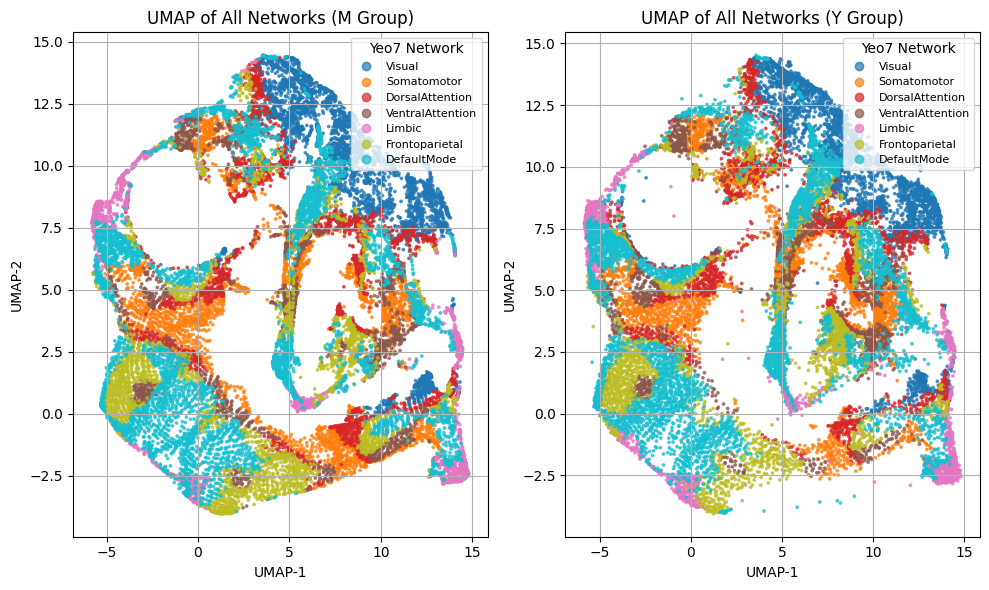

In [ ]:
#同时降维
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# M组所有脑区拼接 + 标签
m_data_all = []
m_labels = []
y_data_all = []
y_labels = []


for val, points in m_roi.items():
    m_data_all.append(points)
    m_labels.extend([val] * len(points))

for val, points in y_roi.items():
    y_data_all.append(points)
    y_labels.extend([val] * len(points))

m_data_all = np.vstack(m_data_all)
m_labels = np.array(m_labels)

y_data_all = np.vstack(y_data_all)
y_labels = np.array(y_labels)


# 标准化
scaler = StandardScaler()
m_input_data = scaler.fit_transform(m_data_all)
y_input_data = scaler.fit_transform(y_data_all)

from umap import UMAP
import matplotlib.pyplot as plt

# UMAP降维
reducer = UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
reducer.fit(m_input_data)           
m_embedding = reducer.transform(m_input_data)
y_embedding = reducer.transform(y_input_data)

# 绘图（按脑区编号上色）
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
scatter = plt.scatter(m_embedding[:, 0], m_embedding[:, 1], 
                      c=m_labels, cmap='tab10', s=3, alpha=0.7)


handles = scatter.legend_elements()[0]
labels = [f'{yeo7_labels.get(i, f"Network {i}")}' for i in np.unique(m_labels)]
plt.legend(handles, labels, title="Yeo7 Network", loc='best', fontsize=8)

plt.title("UMAP of All Networks (M Group)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
scatter = plt.scatter(y_embedding[:, 0], y_embedding[:, 1], 
                      c=y_labels, cmap='tab10', s=3, alpha=0.7)


handles = scatter.legend_elements()[0]
labels = [f'{yeo7_labels.get(i, f"Network {i}")}' for i in np.unique(y_labels)]
plt.legend(handles, labels, title="Yeo7 Network", loc='best', fontsize=8)

plt.title("UMAP of All Networks (Y Group)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
m_region_points = []
y_region_points = []
region_lables = np.unique(m_labels)
for i in region_lables:
    region_points = []
    for label, point in zip(m_labels, m_embedding):
        if label==i:
            region_points.append(point)
    m_region_points.append(np.array(region_points))

region_lables = np.unique(y_labels)
for i in region_lables:
    region_points = []
    for label, point in zip(y_labels, y_embedding):
        if label==i:
            region_points.append(point)
    y_region_points.append(np.array(region_points))



处理第7个脑区
采样后点数：m_sampled=600, y_sampled=600


100%|██████████| 2/2 [00:57<00:00, 28.64s/it]


Iteration 0,	 obj = 0.06953925452322644,	 obj_terms = {'coot': 0.013466535847805558, 'ot': 0.004815730922263128, 'gw': 0.051256987753157755}
Iteration 10,	 obj = 0.020846633155194152,	 obj_terms = {'coot': 0.010707535293766795, 'ot': 0.004222948129726825, 'gw': 0.005916149731700533}
Iteration 20,	 obj = 0.02084160389868194,	 obj_terms = {'coot': 0.010704859497799443, 'ot': 0.004223178628214376, 'gw': 0.005913565772668125}
is_converged, obj = 0.020841589782114582, obj_new = 0.020841589685875087
Time Stamp:1
Time Stamp:2
Time Stamp:3
Time Stamp:4
Time Stamp:5
Time Stamp:6
Time Stamp:7
Time Stamp:8
Time Stamp:9
Time Stamp:10
Time Stamp:11
Time Stamp:12
Time Stamp:13
Time Stamp:14
Time Stamp:15
Time Stamp:16
Time Stamp:17
Time Stamp:18
Time Stamp:19
Time Stamp:20
Time Stamp:21
Time Stamp:22
Time Stamp:23
Time Stamp:24
Time Stamp:25
Time Stamp:26
Time Stamp:27
Time Stamp:28
Time Stamp:29
Time Stamp:30
Time Stamp:31
Time Stamp:32
Time Stamp:33
Time Stamp:34
Time Stamp:35
Time Stamp:36
Time S

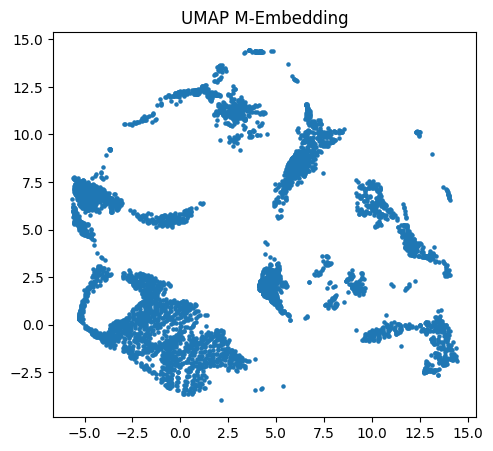

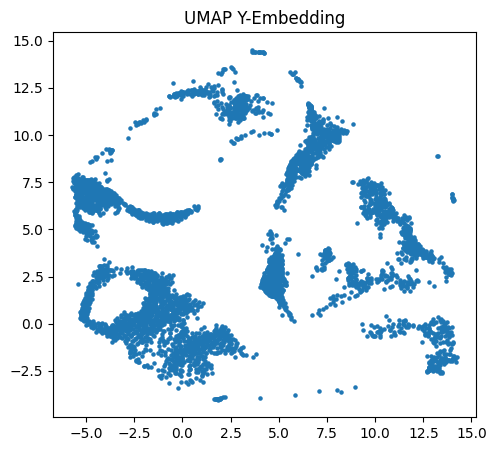

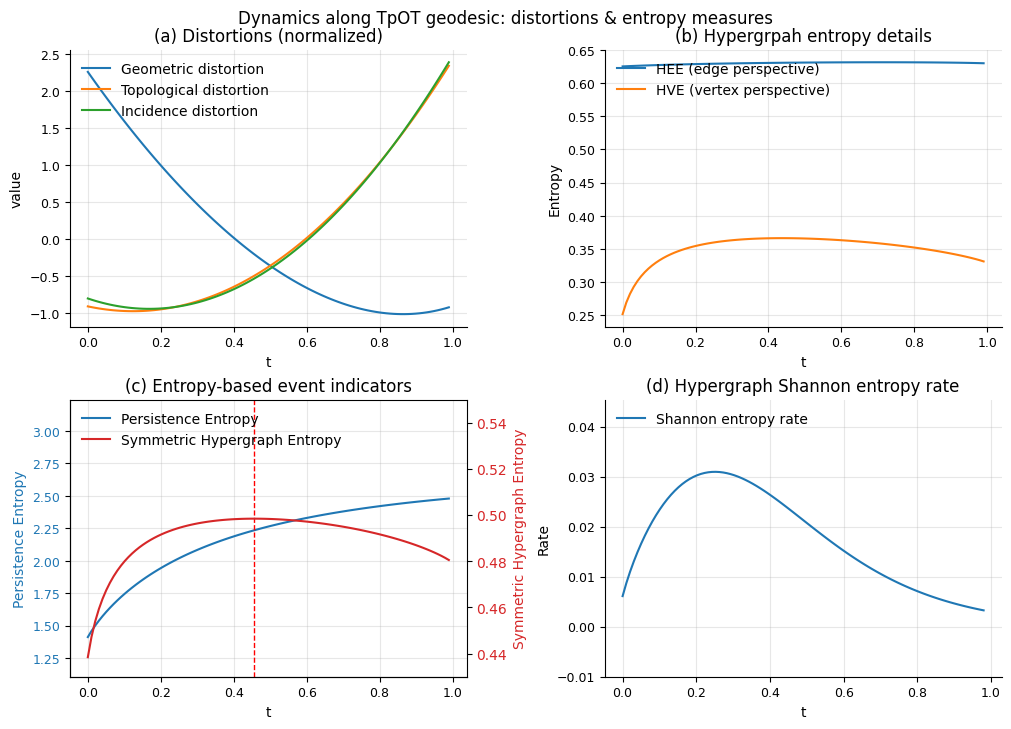

<Figure size 800x800 with 0 Axes>

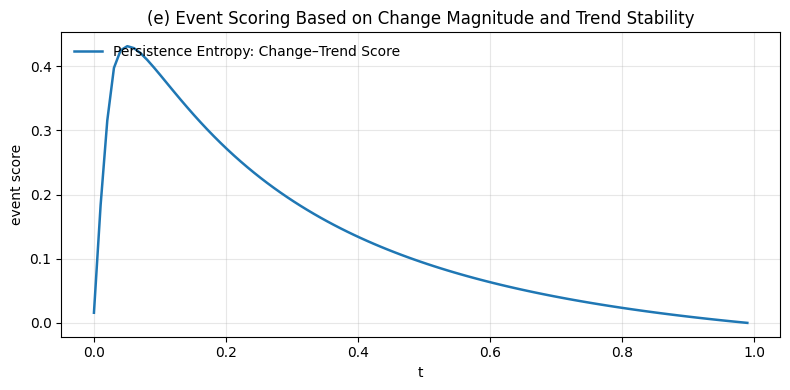

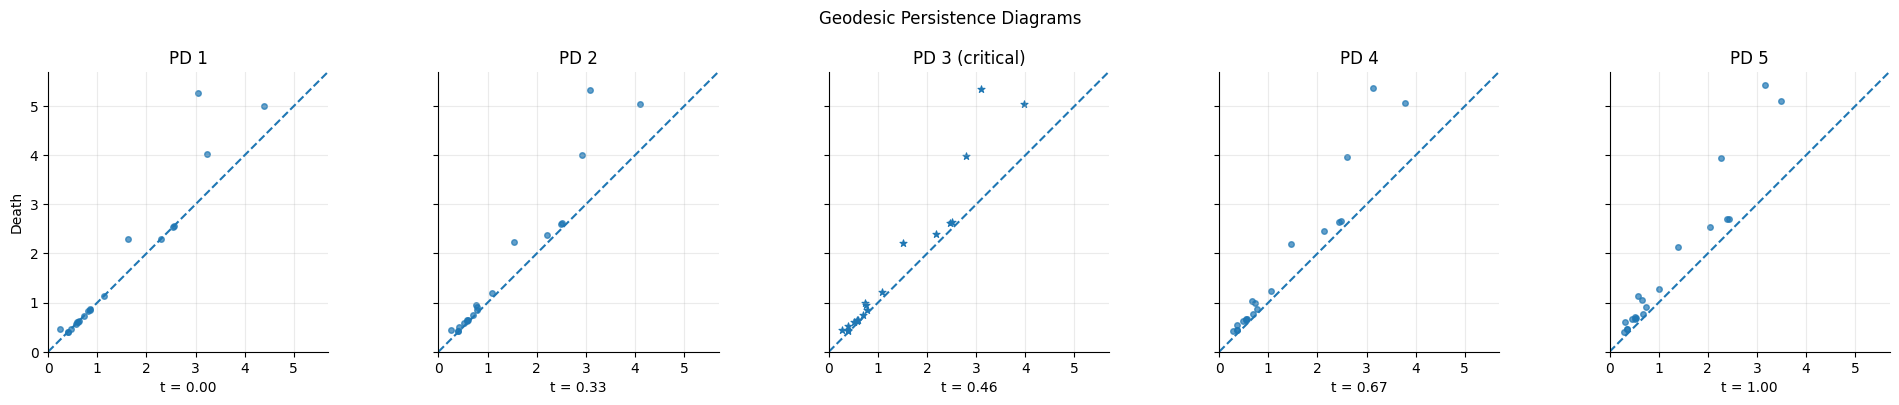

<Figure size 800x800 with 0 Axes>

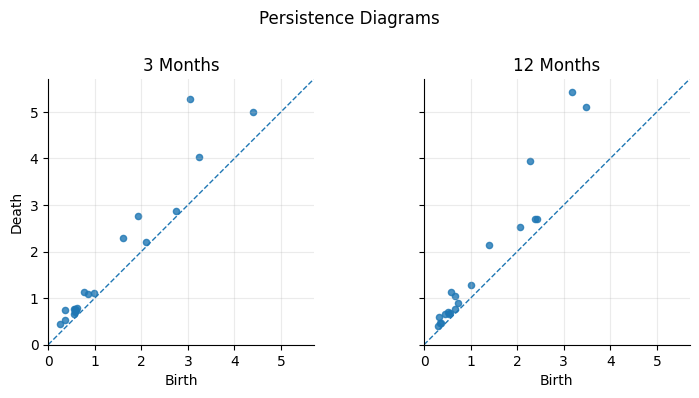

In [ ]:
import sys
sys.path.append("../src/")
sys.path.append("../tools/")
sys.path.append("../tpot/")

import numpy as np
import pandas
import importlib
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from entropy import persist_entropy, hyper_graph_entropy, hyper_edge_entropy, hypergraph_shannon_entropy
from geodesic import geodesic_distances, convex_point, geodesic_distances_gw, geodesic_distances_coot, geodesic_distances_iota

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
import sklearn as sk
import sklearn.decomposition
import math
import pd
import hypernetx as hnx
import tpot
sys.path.append("../tools/topf/src/topf")
#import topf
import topfmain


yeo_hge_values = []
yeo_hee_values = []
yeo_sym_values = []
yeo_hse_rate = []
#for segment in range(7):
for segment in range(6,7):
    print(f'处理第{segment+1}个脑区')

    m_embedding = m_region_points[segment]
    y_embedding = y_region_points[segment]

    # 可视化
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(m_embedding[:, 0], m_embedding[:, 1], s=5)
    plt.title("UMAP M-Embedding")
    name = '/Volumes/Extreme SSD/工程/TpOT/tpot/figures/' + 'whole' + str(segment+1) + '_m_embedding.png'
    plt.savefig(name)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 2)
    plt.scatter(y_embedding[:, 0], y_embedding[:, 1], s=5)
    plt.title("UMAP Y-Embedding")
    name = '/Volumes/Extreme SSD/工程/TpOT/tpot/figures/' + 'whole' + str(segment+1) + '_y_embedding.png'
    plt.savefig(name)

    import numpy as np

    N_m, N_y = m_embedding.shape[0], y_embedding.shape[0]

    # 随机种子
    rng = np.random.default_rng(seed=42)

        # 从 m_embedding 中无放回抽样 N_y 个点
    idx = rng.choice(N_m, size=600, replace=False)
    m_sampled = m_embedding[idx]


    idx = rng.choice(N_y, size=600, replace=False)
    y_sampled = y_embedding[idx]


    print(f"采样后点数：m_sampled={len(m_sampled)}, y_sampled={len(y_sampled)}")

    
    A = m_sampled
    B = y_sampled
    # Compute pairwise distance matrices for source A and target B
    def get_affinities(X, gaussian = True):
        C = sp.spatial.distance.cdist(X, X, metric = "sqeuclidean")
        C /= np.mean(C)
        if gaussian:
            C = np.exp(-C)
        return C
    C_v0, C_v1 = get_affinities(A), get_affinities(B)
    p, q = ot.unif(len(A)), ot.unif(len(B))

    topf_all = [topfmain.topf(x, return_dict = True, complex_type = 'rips', fixed_num_features = [0, 20]) for x in tqdm([A, B])]
    y0 = topf_all[0][0]
    y1 = topf_all[1][0]
    df1, df2 = [pandas.DataFrame({"b" : x[1]['birth_times'], "d" : x[1]['death_times'], "pers" : np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])}) for x in topf_all]
    p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

    # Get weights and cost on the PD space 
    p, q = pd.augmented_weights(p_spt, q_spt)
    C = pd.augmented_cost(p_spt, q_spt)
    C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd.mean()

    C_v0, C_v1 = get_affinities(A), get_affinities(B)

    alpha = 0.7
    beta = 1

    w0 = ot.unif(y0.shape[0])
    w1 = ot.unif(y1.shape[0])
    v0 = p
    v1 = q
    pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1, 
                            C_v0, C_v1, C_pd, 
                            beta = beta, alpha = alpha, print_iter = 10, iter = 100,
                            solver = "sinkhorn", 
                            eps_s = 0.003, eps_f = 0.01, numItermax = 2500)

    P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
    Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
    Q[np.isnan(Q)] = 0

    # Find geodesic
    matching = np.array(np.where(ot.emd(w0, w1, pi_s.max()-pi_s) > 0)).T # round coupling


    ######计算三个测地距离矩阵###############
    point_matching = []
    pi_s_T = pi_s.T
    for i in range(len(pi_s_T[:][-1])):
        sorted_indices = np.argsort(pi_s_T[i])
        point_matching.append([i, sorted_indices[-1]])

    #计算测地线中的C_pd
    cycle_matching = []
    pi_f_T = pi_f.T
    for i in range(len(pi_f_T[:][-1])):
        sorted_indices = np.argsort(pi_f_T[i])
        cycle_matching.append([i, sorted_indices[-1]])



    import numpy as np
    from coot import dot, eta

    def compute_coot_ot_gw_distances(X1, X2, C1, C2, C_pd, pi_s, pi_f, alpha, beta):
        # 添加零列处理扩展矩阵
        _X1 = np.hstack([X1, np.zeros((X1.shape[0], 1))])
        _X2 = np.hstack([X2, np.zeros((X2.shape[0], 1))])
        
        # 计算COOT项
        coot_term = dot(
            eta(_X1, _X2, pi_f.sum(-1), pi_f.sum(0)) - _X1 @ pi_f @ _X2.T,
            pi_s
        )
        
        # 计算OT项
        ot_term = dot(C_pd, pi_f)
        
        # 计算GW项
        gw_term = dot(
            eta(C1, C2, pi_s.sum(-1), pi_s.sum(0)) - C1 @ pi_s @ C2.T,
            pi_s
        )
        
        # 应用权重参数
        coot_dist = beta * coot_term
        ot_dist = (1 - alpha) * ot_term
        gw_dist = alpha * gw_term
        
        return coot_dist, ot_dist, gw_dist


    ###############用距离矩阵计算测地线####################
    num_frames = 100

    coot_values = []
    ot_values = []
    gw_values = []
    total_values = []
    pe_values = []#persistent entropy
    hge_values = []#hyper graph entropy(new defined)
    hse_values = []#hypergraph shannon entropy
    hee_values = []#hyperedge entropy
    geodesic_pd = []#PD on the geodesic
    sym_values = []#symmetric hypergraph entropy
    geodesic_pd.append(p_spt)

    para_alpha = 0.5
    for i in range(1,num_frames):
        t = i/num_frames
        y1_t = geodesic_distances_coot(y1,y0,t,point_matching,cycle_matching)
        C2_t = geodesic_distances_gw(B,A,t, point_matching)
        geodesic_pd_point = geodesic_distances_iota(q_spt, p_spt, t, cycle_matching)

        if i%25 == 0:
            geodesic_pd.append(geodesic_pd_point)

        pe_value = persist_entropy(geodesic_pd_point)
        hge_value = hyper_graph_entropy(y1_t)
        hee_value = hyper_edge_entropy(y1_t)
        hse_value = hypergraph_shannon_entropy(y1_t)

        p, q = pd.augmented_weights(p_spt, geodesic_pd_point)
        C = pd.augmented_cost(p_spt, geodesic_pd_point)
        C_pd_t = pd.augmented_cost(p_spt, geodesic_pd_point); C_pd_t /= C_pd_t.mean()
        C_v1_t = C2_t
        C_v1_t /= np.mean(C2_t)
        C_v1_t = np.exp(-C_v1_t)
        value = compute_coot_ot_gw_distances(y0, y1_t,
                            C_v0, C_v1_t, C_pd_t, 
                            pi_s, pi_f,
                            alpha = alpha, beta=beta)
        coot_values.append(value[0])
        ot_values.append(value[1])
        gw_values.append(value[2])
        total_values.append(value[0]+value[1]+value[2])

        pe_values.append(pe_value)
        hge_values.append(hge_value)
        hee_values.append(hee_value)
        hse_values.append(hse_value)
        sym_values.append(para_alpha * hge_value + (1-para_alpha) * hee_value)
        print(f'Time Stamp:{i}')

    hse_rate = [hse_values[i] - hse_values[i-1] for i in range(1,len(hse_values))]
    hge_rate = [hge_values[i] - hge_values[i-1] for i in range(1,len(hge_values))]


    import numpy as np
    import matplotlib.pyplot as plt

    # x 轴
    x = np.arange(len(ot_values))

    # distortions
    geom = np.asarray(gw_values) 
    topo = np.asarray(ot_values) 
    hyper = np.asarray(coot_values)

    # entropies
    PE = np.asarray(pe_values)           # Persistence entropy
    HE = np.asarray(hge_values)          # Hypergraph entropy
    HEE = np.asarray(hee_values)         # Hyperedge-perspective entropy
    SHE = np.asarray(sym_values)         # Symmetric hypergraph entropy

    # 参考：Shannon entropy rate
    HSE_rate = np.asarray(hse_rate)

    # z-score 标准化
    def zscore(y):
        y = np.asarray(y, dtype=float)
        m, s = np.nanmean(y), np.nanstd(y)
        return (y - m) / s if s > 0 else y * 0.0

    geom_z, topo_z, hyper_z = map(zscore, [geom, topo, hyper])
    PE_z, HE_z, HEE_z, SHE_z = map(zscore, [PE, HE, HEE, SHE])

    event_idx = int(np.nanargmax(SHE))

    # ==== 画图 ====
    fig = plt.figure(figsize=(10, 7), constrained_layout=True)
    gs = fig.add_gridspec(2, 2)

    axA = fig.add_subplot(gs[0, 0])  # (a)
    axB = fig.add_subplot(gs[1, 0])  # (c)
    axC = fig.add_subplot(gs[0, 1])  # (b)
    axD = fig.add_subplot(gs[1, 1])  # (d)

    # (a) Distortions (z-score)
    axA.plot(x/(num_frames-1), geom_z, label='Geometric distortion')
    axA.plot(x/(num_frames-1), topo_z, label='Topological distortion')
    axA.plot(x/(num_frames-1), hyper_z, label='Incidence distortion')
    #axA.axvline(event_idx/(num_frames-1), linestyle='--')
    axA.set_title('(a) Distortions (normalized)')
    axA.set_xlabel('t')
    axA.set_ylabel('value')
    axA.grid(True, alpha=0.3)
    axA.legend(loc='upper left', ncol=1, frameon=False)

    # (b) Entropy-based event indicators (dual-axis)
    color_left = 'tab:blue'
    color_right = 'tab:red'

    # 左轴：Persistence Entropy
    axB.plot(x / (num_frames - 1), PE, color=color_left, label='Persistence Entropy')
    axB.set_xlabel('t')
    axB.set_ylabel('Persistence Entropy', color=color_left)
    axB.tick_params(axis='y', labelcolor=color_left)
    axB.grid(True, alpha=0.3)

    # 右轴：Symmetric Hypergraph Entropy
    axB_r = axB.twinx()
    axB_r.plot(x / (num_frames - 1), SHE, color=color_right, label='Symmetric Hypergraph Entropy')
    axB_r.set_ylabel('Symmetric Hypergraph Entropy', color=color_right)
    axB_r.tick_params(axis='y', labelcolor=color_right)

    she_mean = np.nanmean(SHE)
    she_range = np.nanmax(SHE) - np.nanmin(SHE)
    pe_mean = np.nanmean(PE)
    pe_range = np.nanmax(PE) - np.nanmin(PE)
    axB.set_ylim(pe_mean - 1 * pe_range, pe_mean + 1 * pe_range)
    axB_r.set_ylim(she_mean - 1 * she_range, she_mean + 1 * she_range)

    axB.axvline(event_idx / (num_frames - 1), linestyle='--', color='red', linewidth=1)

    # 标题与图例
    axB.set_title('(c) Entropy-based event indicators')
    lines, labels = axB.get_legend_handles_labels()
    lines2, labels2 = axB_r.get_legend_handles_labels()
    axB.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

    # 合并左右两轴的图例
    lines, labels = axB.get_legend_handles_labels()
    lines2, labels2 = axB_r.get_legend_handles_labels()
    axB.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

    # (c) Vertex vs Edge incidence entropy
    axC.plot(x/(num_frames-1), HEE, label='HEE (edge perspective)')
    axC.plot(x/(num_frames-1), HE, label='HVE (vertex perspective)')
    # axC.plot(x, HEV, label='HEV (vertex perspective)')
    #axC.axvline(event_idx/(num_frames-1), linestyle='--')
    axC.set_title('(b) Hypergrpah entropy details')
    axC.set_xlabel('t')
    axC.set_ylabel('Entropy')
    axC.grid(True, alpha=0.3)
    axC.legend(loc='upper left', ncol=1, frameon=False)

    # (d) Shannon hypergraph entropy rate（参考底噪）
    axD.plot(x[:-1]/(num_frames-1), HSE_rate, label='Shannon entropy rate')
    HSE_rate_mean = np.nanmean(HSE_rate)
    HSE_rate_range = np.nanmax(HSE_rate) - np.nanmin(HSE_rate)
    axD.set_ylim(HSE_rate_mean - 1 * HSE_rate_range, HSE_rate_mean + 1* HSE_rate_range)
    #axD.axvline(event_idx/(num_frames-1), linestyle='--')
    axD.set_title('(d) Hypergraph Shannon entropy rate')
    axD.set_xlabel('t')
    axD.set_ylabel('Rate')
    axD.grid(True, alpha=0.3)
    axD.legend(loc='upper left', ncol=1, frameon=False)

    # 面板整体优化
    for ax in [axA, axB, axC, axD]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=9)

    fig.suptitle('Dynamics along TpOT geodesic: distortions & entropy measures', y=1.02)
    # 保存高分辨 & 矢量
    #plt.savefig('figure8_reworked.pdf', bbox_inches='tight')
    #plt.savefig('figure8_reworked.png', dpi=400, bbox_inches='tight')
    plt.show()

    plt.tight_layout()
    name = '/Volumes/Extreme SSD/工程/TpOT/tpot/figures/' + 'whole' + str(segment+1) + '_curves'
    plt.savefig(name)

    plt.tight_layout()
    plt.show()

    #包含event_id的绘图
    geodesic_pd = []  # 每项：{'pd': ndarray(k,2), 't': float, 'is_event': bool}

    for i in range(num_frames):
        t = i / (num_frames - 1)  # [0,1]
        pd_i = geodesic_distances_iota(q_spt, p_spt, t, cycle_matching)
        is_event = i == event_idx + 1

        # 头尾 + 每 25 帧 + 关键帧
        if i == 0 or i == num_frames-1 or (i % 33 == 0) or is_event:
            geodesic_pd.append({'pd': pd_i, 't': (t), 'is_event': is_event})

    import numpy as np
    import matplotlib.pyplot as plt

    def plot_geodesic_pds(geodesic_pd):
        n = len(geodesic_pd)
        fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)

        # 取所有 PD 的最大坐标用于统一坐标轴
        all_vals = np.concatenate([d['pd'].reshape(-1) for d in geodesic_pd])
        vmax = float(np.nanmax(all_vals))
        lim = vmax * 1.05 if vmax > 0 else 1.0

        # 允许 n==1 时 axes 不是数组
        if n == 1: axes = [axes]

        for i, d in enumerate(geodesic_pd):
            ax = axes[i]
            pd = d['pd']; t = d['t']; is_event = d['is_event']

            births = pd[:, 0]; deaths = pd[:, 1]
            # 普通帧：淡蓝圆点；关键帧：红色星标 + 较大 size
            if not is_event:
                ax.scatter(births, deaths, s=16, alpha=0.7)
            else:
                ax.scatter(births, deaths, s=28, marker='*', linewidths=0.8)

            # 对角线
            ax.plot([0, lim], [0, lim], linestyle='--')

            ax.set_xlim(0, lim); ax.set_ylim(0, lim)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlabel(f"t = {t:.2f}")
            if i == 0: ax.set_ylabel("Death")

            ttl = f"PD {i+1}" + (" (critical)" if is_event else "")
            ax.set_title(ttl)

            ax.grid(alpha=0.25)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        fig.suptitle("Geodesic Persistence Diagrams")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        pd_name = '/Volumes/Extreme SSD/工程/TpOT/tpot/figures/' + 'whole' + str(segment+1) + 'pd'
        plt.savefig(pd_name)
    plot_geodesic_pds(geodesic_pd)


    #画两个同调图
    import numpy as np
    import matplotlib.pyplot as plt

    def plot_two_pds(p_spt, q_spt, titles=("3 Months", 
                                            "12 Months"), 
                    save_path=None):
        """
        Plot only two persistence diagrams: p_spt and q_spt.
        Parameters
        ----------
        p_spt, q_spt : ndarray, shape (k, 2)
            Birth–death pairs of two persistence diagrams.
        titles : tuple[str, str]
            Titles for the two subplots.
        save_path : str or None
            Optional path to save the figure.
        """
        # unify axis range
        arrs = []
        if p_spt is not None and len(p_spt) > 0:
            arrs.append(np.asarray(p_spt).reshape(-1))
        if q_spt is not None and len(q_spt) > 0:
            arrs.append(np.asarray(q_spt).reshape(-1))

        if len(arrs) == 0:
            raise ValueError("At least one of p_spt or q_spt must be non-empty.")

        all_vals = np.concatenate(arrs)
        vmax = float(np.nanmax(all_vals)) if all_vals.size else 1.0
        lim = vmax * 1.05 if vmax > 0 else 1.0

        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

        for ax, pd_arr, ttl in zip(axes, (p_spt, q_spt), titles):
            pd_arr = np.asarray(pd_arr)
            if pd_arr.size > 0:
                births = pd_arr[:, 0]
                deaths = pd_arr[:, 1]
                ax.scatter(births, deaths, s=20, alpha=0.8)
            ax.plot([0, lim], [0, lim], linestyle='--', linewidth=1)
            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlabel("Birth")
            ax.set_title(ttl)
            ax.grid(alpha=0.25)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        axes[0].set_ylabel("Death")
        fig.suptitle("Persistence Diagrams")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")

        plt.show()
        return fig, axes

    # Example usage:
    plot_two_pds(p_spt, q_spt)




    yeo_hge_values.append(hge_values)
    yeo_hee_values.append(hee_values)
    yeo_sym_values.append(sym_values)
    yeo_hse_rate.append(hse_rate)


In [8]:
# Find geodesic
matching = np.array(np.where(ot.emd(w0, w1, pi_s.max()-pi_s) > 0)).T # round coupling
def geodesic_distances(a,b,t,indices):
    #Compute pairwise distance between points in geodesic
    N = len(indices)
    M = np.zeros((N, N))
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        for jj in range(ii+1, N):
            Pj = a[indices[jj][0]]
            Qj = b[indices[jj][1]]
            
            Pj = np.array(Pj)
            Qj = np.array(Qj)
            da = np.linalg.norm(Pi - Pj)
            db = np.linalg.norm(Qi - Qj)
            M[ii][jj] = (1-t)* da + t*db
    return M + M.T 

def convex_point(a,b,t,indices):
    N = len(indices)
    v = []
    for ii in range(N):

        Pi = a[indices[ii][0]]
        Qi = b[indices[ii][1]]
        Pi = np.array(Pi)
        Qi = np.array(Qi)
        v.append( Pi*(1-t) + Qi*t)
    return v

num_frames = 100
x1 = np.linspace(0, 1, num_frames, endpoint=True)
matrices = [geodesic_distances(A,B,t, matching) for t in x1]
convex_points = np.array([convex_point(A,B,t, matching) for t in x1])

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances

model = MDS(n_components=2, dissimilarity='precomputed', random_state=2002)

from scipy.spatial.transform import Rotation as R
def align(AA,BB):
    AA = [[aa[0], aa[1], 0] for aa in AA]
    BB = [[aa[0], aa[1], 0] for aa in BB]
    rot, rssd, sens = R.align_vectors(BB, AA, return_sensitivity=True)
    return rot.apply(AA)[:,:2]
def reflect(a):
    return np.array([ [aa[0], -aa[1]] for aa in a ])

import warnings
warnings.filterwarnings("ignore")
models = []
out = model.fit(matrices[0]).embedding_
pos = align(out, convex_points[0])
models_alligned = [pos]
for ii in range(1, num_frames):
    true = convex_points[ii]
    out = model.fit(matrices[ii]).embedding_
    pos = align(out, true)
    rpos = reflect(pos)
    #if np.linalg.norm(models_alligned[-1] - pos) >  np.linalg.norm(models_alligned[-1] - rpos):
    #if ii <= 55:
    #    pos = rpos
    models.append(out)
    models_alligned.append(pos)



In [ ]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from io import BytesIO
import imageio.v2 as imageio


frames = []
for i in range(num_frames):
    df = pandas.DataFrame()
    arr = np.array(models_alligned[i])
    df['x'] = arr[:, 0]
    df['y'] = arr[:, 1]
    df['frame'] = i
    frames.append(df)

DF = pandas.concat(frames, ignore_index=True)
DF['size'] = 3  

# ===== 计算全局坐标范围，确保所有帧尺度一致 =====
xmin, xmax = DF['x'].min(), DF['x'].max()
ymin, ymax = DF['y'].min(), DF['y'].max()
# 适度留白
pad_x = 0.05 * (xmax - xmin if xmax > xmin else 1.0)
pad_y = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
xlim = (xmin - pad_x, xmax + pad_x)
ylim = (ymin - pad_y, ymax + pad_y)

# ===== 逐帧绘制并写入 GIF =====
imgs = []
dpi = 100
width_px, height_px = 600, 500
figsize = (width_px / dpi, height_px / dpi)

# size 映射到 matplotlib 的点面积（points^2）
size_scale = 6.0  # 可调大/小来改变整体点大小

for i in range(num_frames):
    fdf = DF[DF['frame'] == i]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.scatter(fdf['x'].values, fdf['y'].values,
               s=(fdf['size'].values * size_scale),
               c='gray', edgecolors='none')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()

    # 保存到内存并读入为 imageio 帧
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0.02)
    plt.close(fig)
    buf.seek(0)
    imgs.append(imageio.imread(buf))

# 帧间隔（秒）：0.03 ≈ 33 FPS
imageio.mimsave('models_aligned_animation.gif', imgs, duration=0.03)
print('✅ GIF saved to models_aligned_animation.gif')

✅ GIF saved to models_aligned_animation.gif


处理第7个脑区：代表环超图熵差值 ΔH + 点云上色
采样后点数：m=600, y=600


100%|██████████| 2/2 [00:57<00:00, 28.66s/it]


Iteration 0,	 obj = 0.03873466187033459,	 obj_terms = {'coot': 0.0066727047055543665, 'ot': 0.008506538381346218, 'gw': 0.02355541878343401}
Iteration 10,	 obj = 0.018408155236754667,	 obj_terms = {'coot': 0.0057206643426290634, 'ot': 0.00820338701259483, 'gw': 0.004484103881530773}
Iteration 20,	 obj = 0.018409511558157447,	 obj_terms = {'coot': 0.005720932056116377, 'ot': 0.008203566582430637, 'gw': 0.004485012919610432}
is_converged, obj = 0.01840951804909534, obj_new = 0.018409518783385773
已生成 geodesic 帧：100


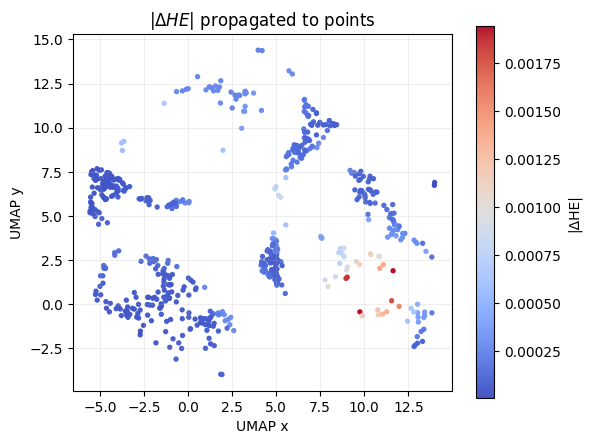

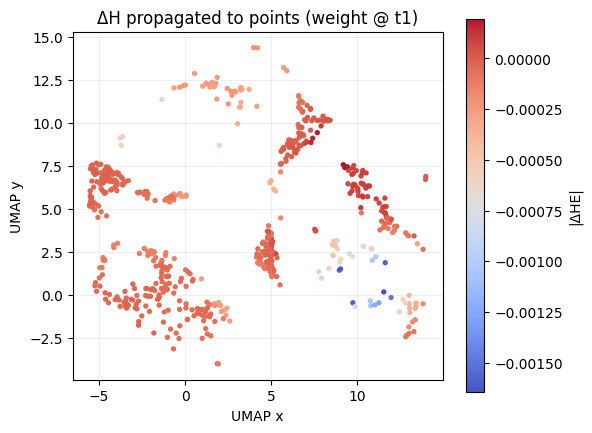

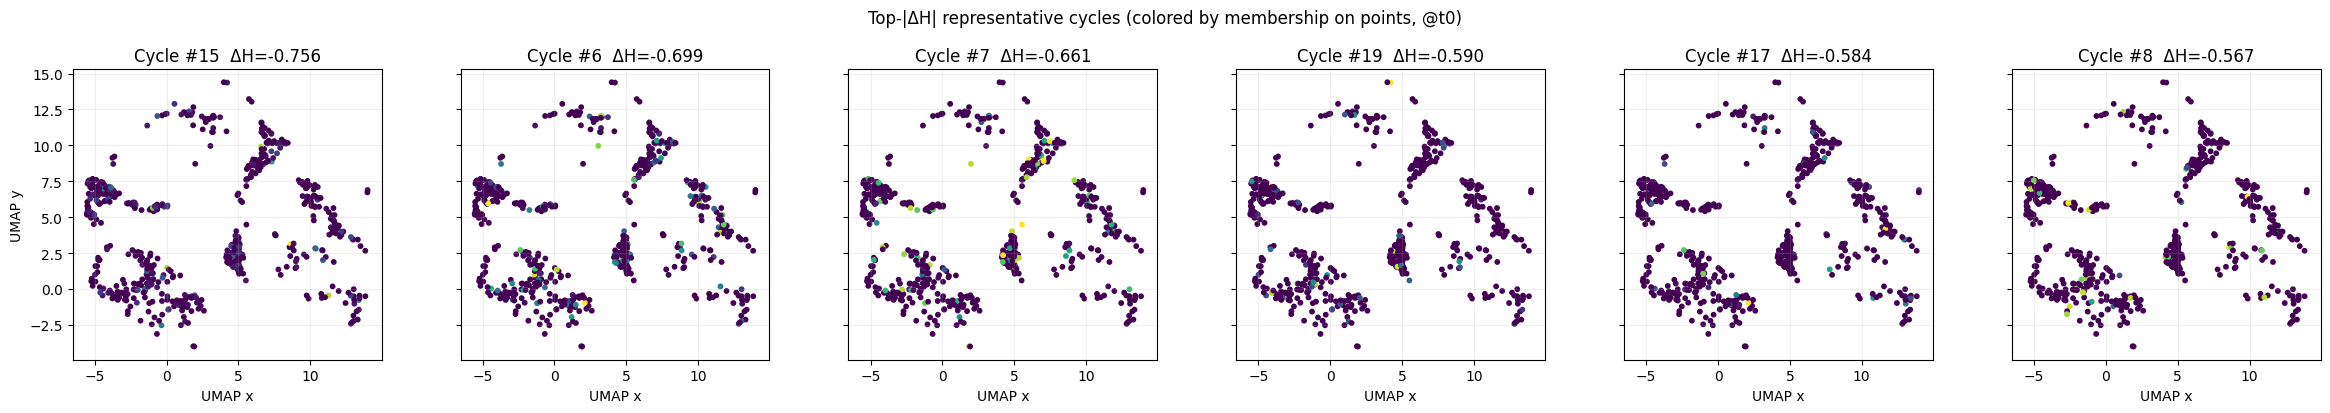

完成：ΔH 点云着色与 Top-K 代表环可视化。输出已保存到： /Volumes/Extreme SSD/工程/TpOT/tpot/figures


In [ ]:
# -*- coding: utf-8 -*-
# 基于代表环—点隶属矩阵的“环熵差值 ΔH”，并把 ΔH 回传到点云上着色

import sys
sys.path.append("../src/")
sys.path.append("../tools/topf/src/topf")

import numpy as np
import pandas
import ot
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy as sp
import math

from entropy import persist_entropy, hyper_graph_entropy, hyper_edge_entropy, hypergraph_shannon_entropy
from geodesic import geodesic_distances_gw, geodesic_distances_coot, geodesic_distances_iota
import pd
import tpot
import topfmain

# ====================== 可调参数 ======================
SEG_IDX = 6                 # 第7个脑区（0-based）
NUM_SAMPLE = 600            # 每类采样点数（按需降低/提高）
NUM_FRAMES = 100            # geodesic 帧数
ALPHA = 0.3                 # tpot alpha
BETA  = 0.5                 # tpot beta
SEED = 42
TOPK_CYCLES = 6             # 可视化 |ΔH| 最大的 K 条代表环
SAVE_DIR = '/Volumes/Extreme SSD/工程/TpOT/tpot/figures'  # 输出目录
USE_EVENT_FRAME = False     # 如果想用事件帧，把它改 True 并提供 event_idx

# ====================== 工具函数 ======================
def get_affinities(X, gaussian=True):
    C = sp.spatial.distance.cdist(X, X, metric="sqeuclidean")
    C /= np.mean(C)
    if gaussian:
        C = np.exp(-C)
    return C

def align_cycles(M_ref, M_tar, cycle_matching):
    """
    用 cycle_matching 将目标矩阵 M_tar 的“环列”对齐到参考矩阵 M_ref 的列顺序。
    cycle_matching: list[[j_tar, j_ref], ...]
    返回对齐后的 M_tar_aligned，列数与 M_ref 相同，不匹配的列为 0。
    """
    pairs = np.array(cycle_matching, dtype=int)
    j_tar, j_ref = pairs[:, 0], pairs[:, 1]
    keep = j_ref < M_ref.shape[1]
    j_tar = j_tar[keep]; j_ref = j_ref[keep]
    M_align = np.zeros((M_tar.shape[0], M_ref.shape[1]), dtype=float)
    if len(j_tar) > 0:
        M_align[:, j_ref] = M_tar[:, j_tar]
    return M_align

def col_normalize(M, eps=1e-12):
    M = np.clip(M, 0.0, None).astype(float)
    colsum = M.sum(axis=0, keepdims=True)
    colsum = np.maximum(colsum, eps)
    return M / colsum

def cycle_entropy(M_norm, eps=1e-12, normalize_to_01=True):
    """
    M_norm: 每列为环在点上的分布 p_ij（列归一化后）
    返回每条环的 Shannon 熵 H_j；若 normalize_to_01=True，用 log(n) 归一化到 [0,1]
    """
    P = np.clip(M_norm, eps, 1.0)
    H = -np.sum(P * np.log(P), axis=0)
    if normalize_to_01:
        H /= np.log(M_norm.shape[0] + 1e-9)
    return H

def scatter_color_points(points_xy, score, title, save_path=None):
    x, y = points_xy[:, 0], points_xy[:, 1]
    v = (score - np.nanmean(score)) / (np.nanstd(score) + 1e-9)  # z-score
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(x, y, c=score, s=8, cmap='coolwarm', alpha=0.95)
    plt.colorbar(sc, shrink=0.85, label=r'|ΔHE|')
    plt.title(title)
    plt.xlabel('UMAP x'); plt.ylabel('UMAP y')
    plt.grid(alpha=0.2)
    plt.gca().set_aspect('equal', adjustable='box')
    if save_path:
        plt.tight_layout(); plt.savefig(save_path, dpi=300)
    plt.show()

# ====================== 1) 取第7脑区并采样 ======================
print(f'处理第{SEG_IDX+1}个脑区：代表环超图熵差值 ΔH + 点云上色')

rng = np.random.default_rng(seed=SEED)
m_embedding = m_region_points[SEG_IDX]
y_embedding = y_region_points[SEG_IDX]

N_m, N_y = m_embedding.shape[0], y_embedding.shape[0]
idx_m = rng.choice(N_m, size=min(NUM_SAMPLE, N_m), replace=False)
idx_y = rng.choice(N_y, size=min(NUM_SAMPLE, N_y), replace=False)

A = m_embedding[idx_m]  # 源（对应 y0）
B = y_embedding[idx_y]  # 目标（对应 y1）
B_embed = B             # 与 y1（以及 y1_t 序列）的行对齐

print(f"采样后点数：m={len(A)}, y={len(B)}")

# ====================== 2) affinities & PD ======================
C_v0, C_v1 = get_affinities(A), get_affinities(B)

topf_all = [topfmain.topf(x, return_dict=True, complex_type='rips',
                          fixed_num_features=[0, 20]) for x in tqdm([A, B])]
y0 = topf_all[0][0]
y1 = topf_all[1][0]

df1, df2 = [pandas.DataFrame({
    "b": x[1]['birth_times'],
    "d": x[1]['death_times'],
    "pers": np.array(x[1]['death_times']) - np.array(x[1]['birth_times'])
}) for x in topf_all]
p_spt, q_spt = df1.iloc[:, :2].values, df2.iloc[:, :2].values

# PD 空间加权与代价
p_aug, q_aug = pd.augmented_weights(p_spt, q_spt)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd.mean()

# ====================== 3) TPOT 求全局耦合 ======================
w0 = ot.unif(y0.shape[0]); w1 = ot.unif(y1.shape[0])
v0 = p_aug; v1 = q_aug

pi_s, pi_f, _ = tpot.TPOT(
    y0, y1, w0, w1, v0, v1,
    C_v0, C_v1, C_pd,
    beta=BETA, alpha=ALPHA, print_iter=10, iter=100,
    solver="sinkhorn", eps_s=0.003, eps_f=0.01, numItermax=2500
)

# 点/环匹配
# 点匹配：按列最大
point_matching = []
pi_s_T = pi_s.T
for i in range(len(pi_s_T[:][-1])):
    sorted_indices = np.argsort(pi_s_T[i])
    point_matching.append([i, sorted_indices[-1]])
# 环匹配：按列最大
cycle_matching = []
pi_f_T = pi_f.T
for i in range(len(pi_f_T[:][-1])):
    sorted_indices = np.argsort(pi_f_T[i])
    cycle_matching.append([i, sorted_indices[-1]])

# ====================== 4) geodesic：生成 y1_t / PD_t 序列 ======================
y1_seq = []
pd_seq  = []
for i in range(0, NUM_FRAMES):
    t = i / NUM_FRAMES
    y1_t = geodesic_distances_coot(y1, y0, t, point_matching, cycle_matching)     # 点×环 隶属
    pd_t = geodesic_distances_iota(q_spt, p_spt, t, cycle_matching)               # geodesic 上的 PD
    y1_seq.append(y1_t)
    pd_seq.append(pd_t)

print(f"已生成 geodesic 帧：{len(y1_seq)}")

t0_idx = 0
t1_idx = len(y1_seq) - 1
if USE_EVENT_FRAME:
    raise NotImplementedError("请提供 event_idx 并取消上面一行注释。")

#M0 = y1_seq[t0_idx]       # 参考帧
M0 = y0
M1_raw = y1_seq[t1_idx]   # 目标帧（未对齐列）

# ====================== 5) 对齐代表环列，并计算每条环熵 ΔH ======================
#M0 = align_cycles(M0, M0, cycle_matching)
M1 = align_cycles(M0, M1_raw, cycle_matching)
#M1 = M1_raw

M0n = col_normalize(M0)
M1n = col_normalize(M1)

H0 = cycle_entropy(M0n)   # 每条环在参考帧的熵（归一化到[0,1]）
H1 = cycle_entropy(M1n)   # 每条环在目标帧的熵

dH = H1 - H0              # ΔH per cycle


# ====================== 6) 把 ΔH 回传到点并着色 ======================
# 方式A：用参考帧权重
point_score_ref = M0n @ dH
# 方式B：用目标帧权重
point_score_tar = M1n @ dH
# 方式C：用 |ΔH| 作权重（突出剧烈变化的环）
point_score_abs = M1n @ np.abs(dH)

# 可视化：点云着色
scatter_color_points(
    B_embed, point_score_abs,
    title=r'$|\Delta HE |$ propagated to points', 
    save_path=f'{SAVE_DIR}/seg7_deltaH_points.png'
)
scatter_color_points(
    B_embed, point_score_tar,
    title='ΔH propagated to points (weight @ t1)',
    save_path=f'{SAVE_DIR}/seg7_deltaH_points_tar.png'
)

# ====================== 7) Top-|ΔH| 代表环单独高亮 ======================
K = min(TOPK_CYCLES, dH.shape[0])
order = np.argsort(np.abs(dH))[::-1][:K]

fig, ax = plt.subplots(1, K, figsize=(4*K, 4), sharey=True)
if K == 1: ax = [ax]
for k, j in enumerate(order):
    # 用参考帧的列分布画（也可改用 M1n 看末态）
    pj = M0n[:, j]
    norm_pj = pj / (pj.max() + 1e-12)
    xy = B_embed

    ax_k = ax[k]
    # 灰底
    ax_k.scatter(xy[:, 0], xy[:, 1], s=4, color=(0.85, 0.85, 0.85, 0.35))
    # 高亮该环：按强度着色
    sc = ax_k.scatter(xy[:, 0], xy[:, 1], s=10, c=norm_pj, cmap='viridis', vmin=0, vmax=1)
    ax_k.set_title(f'Cycle #{j}  ΔH={dH[j]:+.3f}')
    ax_k.set_xlabel('UMAP x')
    if k == 0:
        ax_k.set_ylabel('UMAP y')
    ax_k.grid(alpha=0.2)
    ax_k.set_aspect('equal', adjustable='box')

fig.suptitle('Top-|ΔH| representative cycles (colored by membership on points, @t0)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'{SAVE_DIR}/seg7_topK_cycles_deltaH.png', dpi=300)
plt.show()

print("完成：ΔH 点云着色与 Top-K 代表环可视化。输出已保存到：", SAVE_DIR)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import imageio.v2 as imageio
def align_points_rows(M_tar, point_matching, n_ref_rows):
    """
    将目标矩阵 M_tar 的“点行”对齐到参考帧的点顺序（t=0）。
    point_matching: list[[i_tar, i_ref], ...]  或 list[[i_target, i_source], ...]
        与 cycle_matching 的方式一致：第0列是 target(t=1) 的行索引，
        第1列是 ref(t=0) 的行索引。
    n_ref_rows: 参考帧点数（M_ref.shape[0]）
    返回：M_tar_aligned，行数与参考相同；未匹配的行用 0 填。
    """
    M_tar = np.asarray(M_tar, dtype=float)
    row_map = np.full(n_ref_rows, -1, dtype=int)  # ref 行 -> tar 行
    pairs = np.asarray(point_matching, dtype=int)
    i_tar, i_ref = pairs[:, 0], pairs[:, 1]
    keep = (i_ref >= 0) & (i_ref < n_ref_rows) & (i_tar >= 0) & (i_tar < M_tar.shape[0])
    i_tar = i_tar[keep]; i_ref = i_ref[keep]
    row_map[i_ref] = i_tar

    M_align = np.zeros((n_ref_rows, M_tar.shape[1]), dtype=float)
    matched = row_map >= 0
    M_align[matched, :] = M_tar[row_map[matched], :]
    return M_align


M0n = col_normalize(y0)
#M0 = y1_seq[0]
#M0 = align_points_rows(M0, point_matching, M0.shape[0])
#M0 = align_cycles(M0, M0, cycle_matching)
#M0n = col_normalize(M0)

H0  = cycle_entropy(M0n)   # 基准环熵（归一化到[0,1]）

# ---------- 逐帧计算 |δH| 回传点得分 ----------
all_scores = []
all_coords = []
num_frames = len(models_alligned)

delta_mode = "baseline"   # 或 "consecutive"
H_prev = H0.copy()

n_ref_rows = M0.shape[0]  # t=0 的点数
for t in range(num_frames):
    # 1) 取本帧的环—点矩阵
    M_t_raw = y1_seq[min(t, len(y1_seq)-1)]  # (n_target_points, n_target_cycles)



    # 3) 再按环匹配把“列”对齐到基准帧列顺序
    M_t = align_cycles(M0, M_t_raw, cycle_matching)  # (n_ref_points, n_ref_cycles)

    # 4) 列归一化
    M_tn = col_normalize(M_t)

    # 5) 本帧环熵 + 差分
    H_t = cycle_entropy(M_tn)
    if delta_mode == "baseline":
        dH = H_t - H0
    else:
        dH = H_t - H_prev
        H_prev = H_t

    # 6) 回传到点（此时行顺序 = t=0 顺序，正好与 models_alligned 对齐）
    score_t = M_tn @ np.abs(dH)  # (n_ref_points,)
    
    score_t = score_t.reshape(-1, 1)
        # 2) 先按点匹配把“行”对齐到 t=0 的点顺序（与 models_alligned 一致）
    score_t = align_points_rows(score_t, point_matching, n_ref_rows)
    score_t = score_t.squeeze()

    #score_t = (score_t - score_t.mean()) / (score_t.std() + 1e-12) 
    all_scores.append(score_t)
    all_coords.append(np.asarray(models_alligned[t]))  # (n_ref_points, 2)

# ---------- 颜色范围 ----------
stacked = np.concatenate([s[~np.isnan(s)] for s in all_scores])
vmin = np.percentile(stacked, 2)
vmax = np.percentile(stacked, 98)
if np.isclose(vmin, vmax):
    vmin, vmax = float(stacked.min()), float(stacked.max() + 1e-12)

# ---------- 固定坐标范围 ----------
dpi = 100
width_px, height_px = 600, 500
figsize = (width_px/dpi, height_px/dpi)
frame_duration = 0.03

coords_all = np.vstack(all_coords)
xmin, xmax = coords_all[:,0].min(), coords_all[:,0].max()
ymin, ymax = coords_all[:,1].min(), coords_all[:,1].max()
pad_x = 0.05 * (xmax - xmin if xmax > xmin else 1.0)
pad_y = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
xlim = (xmin - pad_x, xmax + pad_x)
ylim = (ymin - pad_y, ymax + pad_y)

# ---------- 逐帧绘图 & GIF ----------
imgs = []
for t in range(num_frames):
    xy = all_coords[t]
    score = all_scores[t]

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sc = ax.scatter(xy[:,0], xy[:,1], c=score, s=10, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ['top','right']: ax.spines[spine].set_visible(False)
    ax.set_title(rf'$|\Delta H|$ propagated to points  (frame {t+1}/{num_frames})', fontsize=11)

    cbar = plt.colorbar(sc, ax=ax, shrink=0.85)
    cbar.set_label(r'$|\Delta H|$', rotation=90)

    plt.tight_layout(pad=0.02)
    buf = BytesIO(); plt.savefig(buf, format='png', dpi=dpi, bbox_inches='tight'); plt.close(fig)
    buf.seek(0); imgs.append(imageio.imread(buf))

#out_path = f'{SAVE_DIR}/seg{SEG_IDX+1}_deltaH_points_H0.gif'
#imageio.mimsave(out_path, imgs, duration=frame_duration)
#print(f'✅ GIF saved to: {out_path}')

✅ GIF saved to: /Volumes/Extreme SSD/工程/TpOT/tpot/figures/seg7_deltaH_points_H0.gif


In [ ]:
# ======= 从这里开始，替换你原来的 Plotly 绘图部分 =======
import numpy as np
import pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math


# 选帧索引：等间隔 + 末帧 + event_idx
step = 25
indices = list(range(0, num_frames, step))
if (num_frames - 1) % step != 0:
    indices.append(num_frames - 1)
if 'event_idx' in locals() and event_idx is not None:
    indices.append(int(event_idx))
indices = sorted(set(indices))

# 2) 汇总为 DataFrame
rows = []
for idx in indices:
    xy = np.asarray(all_coords[idx])
    sc = np.asarray(all_scores[idx]).astype(float)
    rows.append(pandas.DataFrame({
        "x": xy[:, 0],
        "y": xy[:, 1],
        "score": sc,
        "frame": idx
    }))
DF = pandas.concat(rows, ignore_index=True)


mean_s = np.nanmean(DF["score"])
std_s = np.nanstd(DF["score"]) + 1e-9
DF["zscore"] = (DF["score"] - mean_s) / std_s

# 全局色条范围（原始 ΔHE 数值）
vmin = np.percentile(DF["score"].values, 2)
vmax = np.percentile(DF["score"].values, 100)
if np.isclose(vmin, vmax):
    vmin, vmax = float(DF["score"].min()), float(DF["score"].max() + 1e-12)

# 坐标范围
xmin, xmax = DF["x"].min(), DF["x"].max()
ymin, ymax = DF["y"].min(), DF["y"].max()
dx, dy = xmax - xmin, ymax - ymin
pad_x, pad_y = 0.03 * dx, 0.03 * dy
x_range = [xmin - pad_x, xmax + pad_x]
y_range = [ymin - pad_y, ymax + pad_y]

# 子图骨架：两行，列数按需要自动算
n_panels = len(indices)
nrows = 2
ncols = math.ceil(n_panels / nrows)

titles = [
    f"t={(idx+1)/num_frames:.2f} (critical)" if 'event_idx' in locals() and idx == int(event_idx)
    else f"t={idx/num_frames:.2f}"
    for idx in indices
]
# 如果子图格子比面板多，给多余的 title 填空
if len(titles) < nrows * ncols:
    titles = titles + [""] * (nrows * ncols - len(titles))

fig = make_subplots(
    rows=nrows, cols=ncols,
    subplot_titles=titles,
    shared_xaxes=True, shared_yaxes=True,
    horizontal_spacing=0.03,
    vertical_spacing=0.12
)

# coolwarm 渐变（蓝→白→红）
coolwarm_scale = [
    [0.0, '#3b4cc0'],
    [0.1, '#5977e3'],
    [0.2, '#7b9ff9'],
    [0.3, '#9ebeff'],
    [0.4, '#c0d4f5'],
    [0.5, '#dddcdc'],
    [0.6, '#f2cbb7'],
    [0.7, '#f7ac8e'],
    [0.8, '#ee8468'],
    [0.9, '#d65244'],
    [1.0, '#b40426']
]

# 逐格绘图：按 row, col 排两排
for k, idx in enumerate(indices):
    row = k // ncols + 1
    col = k % ncols + 1

    df_i = DF[DF["frame"] == idx]

    fig.add_trace(
        go.Scattergl(
            x=df_i["x"], y=df_i["y"],
            mode="markers",
            marker=dict(
                size=5,
                color=df_i["score"],
                colorscale=coolwarm_scale,
                cmin=vmin, cmax=vmax,
                showscale=(row == 1 and col == ncols),  # 只在右上角那格显示 colorbar
                colorbar=dict(
                    title="|ΔHE|",
                    tickfont=dict(size=10),
                    ticks="outside",
                    tickformat=".4f"
                )
            ),
            showlegend=False
        ),
        row=row, col=col
    )

    fig.update_xaxes(range=x_range, row=row, col=col)
    fig.update_yaxes(range=y_range, scaleanchor="x", scaleratio=1, row=row, col=col)

# event 帧高亮红框
if 'event_idx' in locals() and int(event_idx) in indices:
    k_event = indices.index(int(event_idx))
    row_e = k_event // ncols + 1
    col_e = k_event % ncols + 1

    # 对应的 xaxis / yaxis 编号
    axis_idx = (row_e - 1) * ncols + col_e
    x_key = 'xaxis' + ('' if axis_idx == 1 else str(axis_idx))
    y_key = 'yaxis' + ('' if axis_idx == 1 else str(axis_idx))

    x_dom = fig.layout[x_key].domain
    y_dom = fig.layout[y_key].domain

    fig.add_shape(
        type="rect",
        xref="paper", yref="paper",
        x0=x_dom[0], x1=x_dom[1],
        y0=y_dom[0], y1=y_dom[1],   
        line=dict(width=2, color='red'),
        fillcolor='rgba(255,0,0,0.10)',
        layer="below"
    )

fig.update_layout(
    width=max(350*ncols, 900),
    height=360*nrows,
    margin=dict(l=20, r=20, t=40, b=20),
    title_text=" ",
    template="simple_white"
)

fig.show()


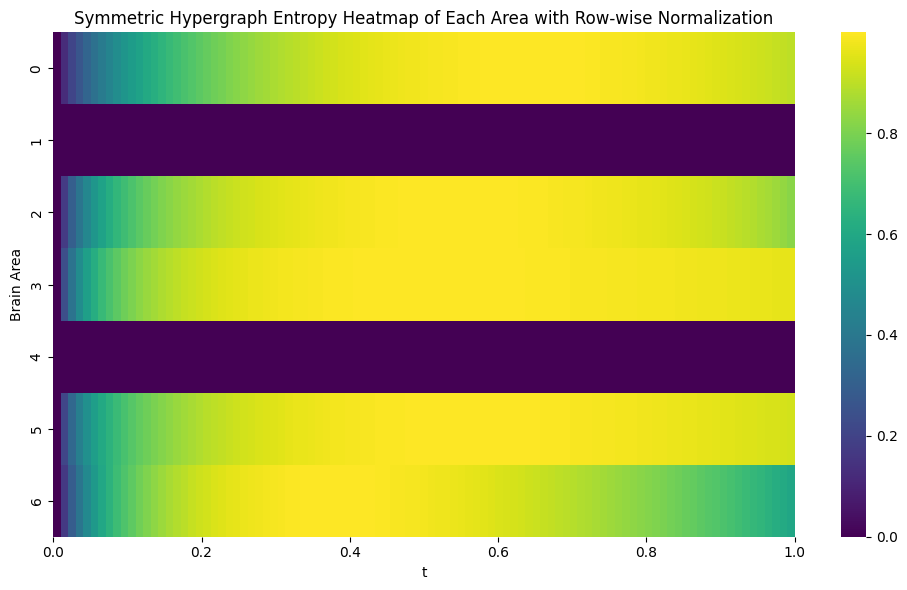

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = np.array(yeo_sym_values)

# 每一行归一化到 [0, 1]
normalized_data = (data - data.min(axis=1, keepdims=True)) / \
                  (data.max(axis=1, keepdims=True) - data.min(axis=1, keepdims=True) + 1e-8)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_data, cmap='viridis', annot=False)

num_cols = normalized_data.shape[1]
xticks = np.linspace(0, num_cols, 6)             # 6个主刻度
xlabels = [f"{x:.1f}" for x in np.linspace(0, 1, 6)]
plt.xticks(xticks, xlabels)
#sns.heatmap(normalized_data, cmap='coolwarm', annot=False)
plt.title("Symmetric Hypergraph Entropy Heatmap of Each Area with Row-wise Normalization")
plt.xlabel("t")
plt.ylabel("Brain Area")
plt.tight_layout()
plt.show()


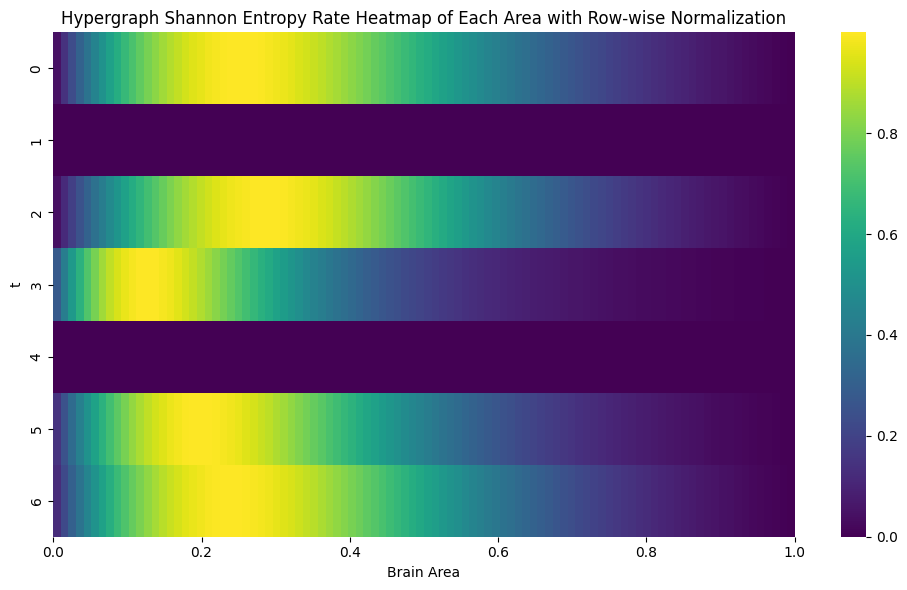

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = np.array(yeo_hse_rate)

# 每一行归一化到 [0, 1]
normalized_data = (data - data.min(axis=1, keepdims=True)) / \
                  (data.max(axis=1, keepdims=True) - data.min(axis=1, keepdims=True) + 1e-8)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_data, cmap='viridis', annot=False)
#sns.heatmap(normalized_data, cmap='coolwarm', annot=False)

num_cols = normalized_data.shape[1]
xticks = np.linspace(0, num_cols, 6)             # 6个主刻度
xlabels = [f"{x:.1f}" for x in np.linspace(0, 1, 6)]
plt.xticks(xticks, xlabels)
plt.title("Hypergraph Shannon Entropy Rate Heatmap of Each Area with Row-wise Normalization")
plt.xlabel("Brain Area")
plt.ylabel("t")
plt.tight_layout()
plt.show()